# Constrained MPC

This notebook accompanies the paper [Learning Convex Optimization Models](https://web.stanford.edu/~boyd/papers/learning_copt_models.html).

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

from cvxpylayers.torch import CvxpyLayer

import latexify
latexify.latexify()
%matplotlib inline

torch.set_default_dtype(torch.double)

In [2]:
n = 10
m = 4
val_seed = 243
np.random.seed(0)
torch.manual_seed(0)
A_np = np.random.randn(n, n)
A_np /= np.max(np.abs(np.linalg.eig(A_np)[0]))
B_np = np.random.randn(n, m)

A = torch.tensor(A_np)
B = torch.tensor(B_np)
weights = torch.randn(n).abs()
weights_np = weights.numpy()
beta = 0.5
T = 5


def dynamics(xt, ut):
    return A @ xt + B @ ut + torch.randn(xt.shape)


def stage_cost(xt, ut):
    cost = 0.    
    return (weights*(xt.pow(2))).sum() + ut.pow(2).sum()

In [3]:
def construct_mpc_problem():
    x = cp.Parameter(n)
    states = [cp.Variable(n) for _ in range(T)]
    controls = [cp.Variable(m) for _ in range(T)]
    constraints = [states[0] == x, cp.norm(controls[0], 'inf') <= beta]
    objective = cp.sum(cp.multiply(weights_np, cp.square(states[0]))) + cp.sum_squares(controls[0])
    for t in range(1, T):
        objective += cp.sum(cp.multiply(weights_np, cp.square(states[t]))) + cp.sum_squares(controls[t])
        constraints += [states[t] == A_np @ states[t-1] + B_np @ controls[t-1]]
        constraints += [cp.norm(controls[t], 'inf') <= beta] 
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return CvxpyLayer(problem, variables=[controls[0]], parameters=[x])

mpc_policy = construct_mpc_problem()

In [4]:
def simulate(policy, n_iters=1000, seed=0):
    torch.random.manual_seed(seed)

    x0 = torch.randn(n)
    states = [x0]
    controls = []
    costs = []
    for t in tqdm(range(n_iters)):
        xt = states[-1]
        ut = policy(xt)[0]
        controls.append(ut)
        costs.append(stage_cost(xt, ut).item())
        states.append(dynamics(xt, ut))
    return states[:-1], controls, costs
    
states, controls, costs = simulate(mpc_policy)
scale = 0.31622776601
torch.manual_seed(1)
for control in controls:
    control.add_(scale*torch.randn(control.shape))
    control.clamp_(-beta, beta)


_, val_mpc_controls, val_mpc_costs = simulate(mpc_policy, seed=val_seed)
for control in val_mpc_controls:
    control.add_(scale*torch.randn(control.shape))
    control.clamp_(-beta, beta)

In [5]:
def mse(preds, actual):
    preds = torch.stack(preds, dim=0)
    actual = torch.stack(actual, dim=0)
    return (preds - actual).pow(2).mean(axis=1).mean(axis=0).item()

In [6]:
_, true_copt_controls, _ = simulate(mpc_policy, seed=val_seed)
true_mse = mse(true_copt_controls, val_mpc_controls)
true_mse

0.06556558185607744

In [7]:
def construct_agent_mpc_problem():
    x = cp.Parameter(n)
    weights = cp.Parameter(n, nonneg=True)
    states = [cp.Variable(n) for _ in range(T)]
    controls = [cp.Variable(m) for _ in range(T)]
    constraints = [states[0] == x, cp.norm(controls[0], 'inf') <= beta]
    objective = cp.sum(cp.multiply(weights, cp.square(states[0]))) + cp.sum_squares(controls[0])
    for t in range(1, T):
        objective += cp.sum(cp.multiply(weights, cp.square(states[t]))) + cp.sum_squares(controls[t])
        constraints += [states[t] == A_np @ states[t-1] + B_np @ controls[t-1]]
        constraints += [cp.norm(controls[t], 'inf') <= beta] 
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return CvxpyLayer(problem, variables=[controls[0]], parameters=[x, weights])

In [8]:
adp_policy = construct_agent_mpc_problem()



weights_tch = torch.ones(n, requires_grad=True)
state_feedback_policy = lambda x: adp_policy(x, weights_tch)

epochs = 20
val_losses = []
losses = []
with torch.no_grad():
    _, initial_preds, _ = simulate(state_feedback_policy, seed=val_seed)
    val_losses.append(mse(initial_preds, val_mpc_controls))
    print(val_losses[-1])
opt = torch.optim.Adam([weights_tch], lr=3e-4)

for epoch in range(epochs):
    print('Epoch: ', epoch)
    for xt, ut in tqdm(zip(states, controls)):
        opt.zero_grad()
        ut_hat = adp_policy(xt, weights_tch)[0]
        loss = (ut - ut_hat).pow(2).mean()
        loss.backward()
        losses.append(loss.item())
        opt.step()
    with torch.no_grad():
        weights_tch.data = weights_tch.relu()
        _, pred_ctrls, _ = simulate(state_feedback_policy, seed=val_seed)
        val_losses.append(mse(pred_ctrls, val_mpc_controls))
    print(val_losses[-1])


0.07279409400252594
Epoch:  0



0.07167800156889442
Epoch:  1



0.07069272655508778
Epoch:  2



0.06984502802297843
Epoch:  3



0.06912690526800701
Epoch:  4



0.0685306250251519
Epoch:  5



0.06801975410008056
Epoch:  6



0.06758384588197658
Epoch:  7



0.06722799115301124
Epoch:  8



0.066928942788196
Epoch:  9



0.06668312239395516
Epoch:  10



0.06648263373470523
Epoch:  11



0.06632072815729703
Epoch:  12



0.06617709680032265
Epoch:  13



0.06605783824574565
Epoch:  14



0.06595958472153375
Epoch:  15



0.06587849367802624
Epoch:  16



0.06581030223823804
Epoch:  17



0.0657534983520345
Epoch:  18



0.0657040754837179
Epoch:  19



0.06566283845623234


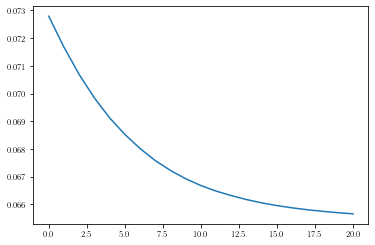

In [9]:
plt.plot(val_losses)

In [10]:
state_feedback_policy = lambda x: adp_policy(x, weights_tch)
agent_states, agent_controls, agent_costs = simulate(state_feedback_policy)

In [11]:
weights_np

array([1.54099611, 0.29342891, 2.17878938, 0.56843128, 1.08452234,
       1.3985954 , 0.40334685, 0.83802633, 0.71925758, 0.40334352])

In [12]:
weights_tch.detach().numpy()

array([1.24226918, 0.20930892, 1.52218022, 0.50380509, 0.65820186,
       1.32770585, 0.53765128, 0.86057136, 0.69989866, 0.76278504])

In [13]:
def plot_weights(w, h):
    fig = plt.figure()
    fig.set_size_inches((w, h))
    plt.plot(weights_tch.detach().numpy(), linestyle='-', color='k', label='learned')
    plt.plot(weights_np, linestyle='--', color='k', label='true')
    plt.xlabel(r'$i$')
    plt.ylabel(r'$\theta_i$')
    plt.legend()
    plt.tight_layout()

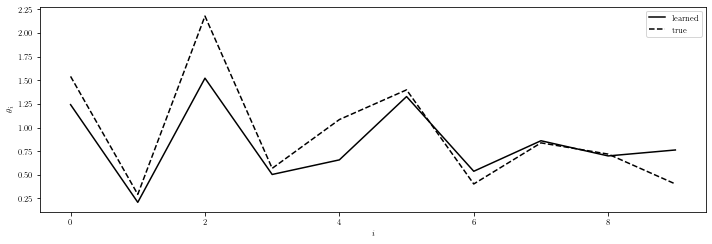

In [14]:
w, h = 10., 3.5
plot_weights(w, h)
plt.show()

### NN

In [15]:
class FF(torch.nn.Module):
    def __init__(self):
        super(FF, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=n, out_features=n)
        self.fc2 = torch.nn.Linear(in_features=n, out_features=m)
        
    def forward(self, x):
        h1 = self.fc1(x).relu()
        return self.fc2(h1).clamp(-beta, beta)

In [16]:
torch.random.manual_seed(0)
ff = FF()


epochs = 100
nn_losses = []
val_nn_losses = []
opt = torch.optim.Adam(ff.parameters(), lr=3e-4)
for epoch in range(epochs):
    print('Epoch: ', epoch)
    for xt, ut in tqdm(zip(states, controls)):
        opt.zero_grad()
        ut_hat = ff(xt)
        loss = (ut - ut_hat).pow(2).mean()
        loss.backward()
        nn_losses.append(loss.item())
        opt.step()
    _, val_preds, _ = simulate(lambda x: [ff(x)], seed=val_seed)
    with torch.no_grad():
        val_nn_losses.append(mse(val_preds, val_mpc_controls))
    print(val_nn_losses[-1])

Epoch:  0



0.13339013895173882
Epoch:  1



0.10390528119402473
Epoch:  2



0.09213862294157092
Epoch:  3



0.08514069016853261
Epoch:  4



0.0807596875666994
Epoch:  5



0.0778797991217785
Epoch:  6



0.07607216173974013
Epoch:  7



0.07487676839845622
Epoch:  8



0.07407347601906784
Epoch:  9



0.0734100136184846
Epoch:  10



0.07284999420013483
Epoch:  11



0.0724048703127036
Epoch:  12



0.07213435839031021
Epoch:  13



0.07184975112360824
Epoch:  14



0.071651381489634
Epoch:  15



0.0714741447227284
Epoch:  16



0.0713748356832925
Epoch:  17



0.0713417187845594
Epoch:  18



0.07128563678241298
Epoch:  19



0.07123416844526928
Epoch:  20



0.07122154078333232
Epoch:  21



0.07118896150178254
Epoch:  22



0.07117927110710451
Epoch:  23



0.07114865851980309
Epoch:  24



0.07116497325584153
Epoch:  25



0.07113427132938849
Epoch:  26



0.07110287066699926
Epoch:  27



0.0710406496446901
Epoch:  28



0.07103545857891705
Epoch:  29



0.0710133721800105
Epoch:  30



0.07099922714044392
Epoch:  31



0.07098492775337684
Epoch:  32



0.0709711586148846
Epoch:  33



0.07094411900377406
Epoch:  34



0.07091195379156302
Epoch:  35



0.070914611431628
Epoch:  36



0.07091209629774217
Epoch:  37



0.07089198430897797
Epoch:  38



0.07088898721963273
Epoch:  39



0.07089111020095054
Epoch:  40



0.0709051743090106
Epoch:  41



0.07088748407378355
Epoch:  42



0.07086211015311936
Epoch:  43



0.07085337679573742
Epoch:  44



0.0708385819455439
Epoch:  45



0.07085073331910073
Epoch:  46



0.07082440141233769
Epoch:  47



0.07085590395020826
Epoch:  48



0.07087409174516461
Epoch:  49



0.07085416433718496
Epoch:  50



0.07086841787127852
Epoch:  51



0.07088161890603432
Epoch:  52



0.07089523274009697
Epoch:  53



0.07090870651654535
Epoch:  54



0.0709239918697194
Epoch:  55



0.07095004718406688
Epoch:  56



0.0709760767504357
Epoch:  57



0.07098092002993424
Epoch:  58



0.07100149287398519
Epoch:  59



0.07099700854800414
Epoch:  60



0.07101549699666969
Epoch:  61



0.07103729849593293
Epoch:  62



0.07105507535216904
Epoch:  63



0.07103927559955972
Epoch:  64



0.07106614978632146
Epoch:  65



0.07109587221059785
Epoch:  66



0.07110370261149217
Epoch:  67



0.07111496417139901
Epoch:  68



0.0711185663396935
Epoch:  69



0.07113188794044005
Epoch:  70



0.07115125072462967
Epoch:  71



0.07117590670579312
Epoch:  72



0.07120024550462467
Epoch:  73



0.07119371334577963
Epoch:  74



0.07120453143587269
Epoch:  75



0.07123343185446906
Epoch:  76



0.07121440668567504
Epoch:  77



0.07120786287464573
Epoch:  78



0.07123596164989206
Epoch:  79



0.07124212266829995
Epoch:  80



0.07123680557621385
Epoch:  81



0.07126244783682108
Epoch:  82



0.07125616539049434
Epoch:  83



0.0712678775267812
Epoch:  84



0.07126775805847482
Epoch:  85



0.07127011578741158
Epoch:  86



0.07127602951288543
Epoch:  87



0.07128220620787919
Epoch:  88



0.07129736372763781
Epoch:  89



0.07132904606273684
Epoch:  90



0.07133475104181279
Epoch:  91



0.07135356375128649
Epoch:  92



0.07133920050625871
Epoch:  93



0.07135837453236582
Epoch:  94



0.07137029098643333
Epoch:  95



0.07136551776936782
Epoch:  96



0.07135427087345948
Epoch:  97



0.0713538413334864
Epoch:  98



0.07137167011417596
Epoch:  99



0.07135701675480081


In [17]:
val_losses[-1]

0.06566283845623234

In [18]:
val_nn_losses[-1]

0.07135701675480081

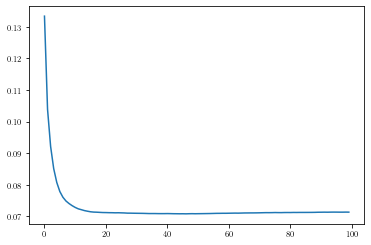

In [19]:
plt.plot(val_nn_losses)

In [20]:
def plot_losses(w, h):
    fig = plt.figure()
    fig.set_size_inches((w, h))
    plt.axhline(val_nn_losses[-1], color='k', linestyle='-.', label='NN')    
    plt.plot(np.arange(len(val_losses)) + 1, val_losses, color='k', label='COM')
    plt.axhline(true_mse, color='k', linestyle='--', label='true')
    plt.xticks([1, 5, 10, 15, 20])
    plt.xlabel('iteration')
    plt.ylabel('validation loss')
    plt.legend(loc='upper right')
    plt.tight_layout()

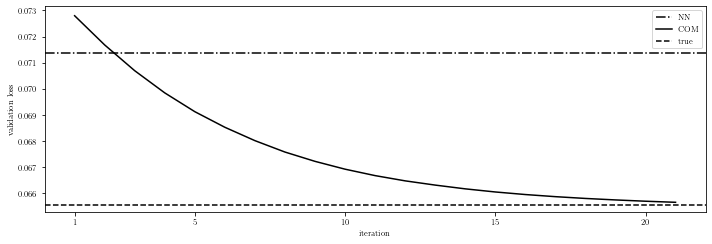

In [21]:
w, h = 10, 3.5
plot_losses(w, h)
plt.show()

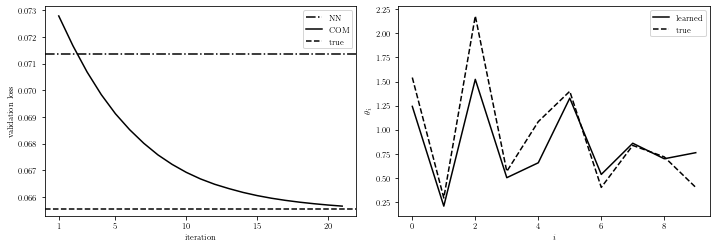

In [22]:
%load_ext autoreload
%autoreload 2

import latexify
latexify.latexify()

w = 10
h = 3.5

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(w, h)

ax[1].plot(weights_tch.detach().numpy(), linestyle='-', color='k', label='learned')
ax[1].plot(weights_np, linestyle='--', color='k', label='true')
ax[1].set_xlabel(r'$i$')
ax[1].set_ylabel(r'$\theta_i$')
ax[1].set_xticks([0, 2,4, 6, 8])
ax[1].legend()
    
ax[0].axhline(val_nn_losses[-1], color='k', linestyle='-.', label='NN')
ax[0].plot(np.arange(len(val_losses)) + 1, val_losses, color='k', label='COM')
ax[0].axhline(true_mse, color='k', linestyle='--', label='true')
ax[0].set_xticks([1, 5, 10, 15, 20])
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('validation loss')
ax[0].legend(loc='upper right')

plt.tight_layout()
plt.show()